## DearMe Project

In [2]:
!pip install fasttext


Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
Failed to build fasttext


  error: subprocess-exited-with-error
  
  × Building wheel for fasttext (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [45 lines of output]
      C:\Users\User\AppData\Local\Temp\pip-build-env-z7ti_7y6\overlay\Lib\site-packages\setuptools\dist.py:599: SetuptoolsDeprecationWarning: Invalid dash-separated key 'description-file' in 'metadata' (setup.cfg), please use the underscore name 'description_file' instead.
      !!
      
              ********************************************************************************
              Usage of dash-separated 'description-file' will not be supported in future
              versions. Please use the underscore name 'description_file' instead.
              (Affected: fasttext).
      
              By 2026-Mar-03, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.h

In [3]:
!pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable


In [4]:
# Import libraries
import pandas as pd
import numpy as np
import re
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from io import StringIO
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Read data

In [12]:
import pandas as pd

# Read both files
test = pd.read_csv(r"C:\Users\User\OneDrive\Desktop\ALISHBA\7th semester\ML\Docker\text-based-emotion-classification-main\src\test.txt", delimiter=';', header=None, names=['sentence', 'label'])
train = pd.read_csv(r"C:\Users\User\OneDrive\Desktop\ALISHBA\7th semester\ML\Docker\text-based-emotion-classification-main\src\train.txt", delimiter=';', header=None, names=['sentence', 'label'])

# Map to binary mood labels
def binary_mood(label):
    if label in ['joy', 'love', 'surprise']:
        return 'positive'
    else:
        return 'negative'

train['binary_label'] = train['label'].apply(binary_mood)
test['binary_label'] = test['label'].apply(binary_mood)

# Combine if needed
df = pd.concat([train, test])

# Show distribution
print("Train Distribution:\n", train['binary_label'].value_counts())
print("\nTest Distribution:\n", test['binary_label'].value_counts())

# View a few rows
train.head()


Train Distribution:
 binary_label
negative    8762
positive    7238
Name: count, dtype: int64

Test Distribution:
 binary_label
negative    1080
positive     920
Name: count, dtype: int64


,sentence,label,binary_label
0,i didnt feel humiliated,sadness,negative
1,i can go from feeling so hopeless to so damned...,sadness,negative
2,im grabbing a minute to post i feel greedy wrong,anger,negative
3,i am ever feeling nostalgic about the fireplac...,love,positive
4,i am feeling grouchy,anger,negative


In [15]:
# Combine train and test datasets
df = pd.concat([train, test])

# Show shape of the combined dataset
print("Combined Data Shape:", df.shape)

# Preview top rows
display(df.head())

# Label distribution (multi-class)
print("\n🔸 Original Emotion Label Distribution (Counts):")
print(df['label'].value_counts())

print("\n🔸 Original Emotion Label Distribution (Percentages):")
print(df['label'].value_counts(normalize=True))

# Test set distribution
print("\n🔹 Test Set Emotion Distribution (Percentages):")
print("Test Set Shape:", test.shape)
print(test['label'].value_counts(normalize=True))


Combined Data Shape: (18000, 3)


,sentence,label,binary_label
0,i didnt feel humiliated,sadness,negative
1,i can go from feeling so hopeless to so damned...,sadness,negative
2,im grabbing a minute to post i feel greedy wrong,anger,negative
3,i am ever feeling nostalgic about the fireplac...,love,positive
4,i am feeling grouchy,anger,negative



🔸 Original Emotion Label Distribution (Counts):
label
joy         6057
sadness     5247
anger       2434
fear        2161
love        1463
surprise     638
Name: count, dtype: int64

🔸 Original Emotion Label Distribution (Percentages):
label
joy         0.336500
sadness     0.291500
anger       0.135222
fear        0.120056
love        0.081278
surprise    0.035444
Name: proportion, dtype: float64

🔹 Test Set Emotion Distribution (Percentages):
Test Set Shape: (2000, 3)
label
joy         0.3475
sadness     0.2905
anger       0.1375
fear        0.1120
love        0.0795
surprise    0.0330
Name: proportion, dtype: float64


# Preprocess text

In [17]:
import nltk
nltk.download('stopwords')  # 🔁 Add this line once at the top

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def clean_data(data):
    stop_words = set(stopwords.words('english'))
    new_data = pd.DataFrame({'sentence': data.sentence, 'label': data.binary_label})
    
    # Clean each sentence
    new_data['sentence'] = data.apply(lambda r: ' '.join(
        w.lower() for w in r['sentence'].split()
        if (w.lower() not in stop_words) and (w.isalpha())
    ), axis=1)

    # Properly filter rows where sentence is not empty
    new_data = new_data[new_data['sentence'].str.strip() != '']
    
    # Drop any rows with missing values
    new_data = new_data.dropna()

    return new_data


In [22]:
df_clean = clean_data(df)
df_clean.to_csv('data_clean.csv')

training_df, testing_df = train_test_split(
    df_clean[['sentence', 'label']].dropna(), 
    test_size=0.2, random_state=2020
)

X_train, X_test, tfidf_vectorizer = extract_features(training_df, testing_df, (1, 2))
y_train = training_df['label'].values
y_test = testing_df['label'].values

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)


In [23]:
def extract_features(train_set, test_set, ngram):

    tfidf=TfidfVectorizer(use_idf=True, max_df=0.95, ngram_range=ngram)
    tfidf.fit_transform(train_set['sentence'].values)

    train_tfidf=tfidf.transform(train_set['sentence'].values)
    test_tfidf=tfidf.transform(test_set['sentence'].values)

    return train_tfidf,test_tfidf,tfidf

In [24]:
df_clean = clean_data(df)
df_clean.to_csv('data_clean.csv')

training_df, testing_df = train_test_split(df_clean[['sentence', 'label']].dropna(), 
                                               test_size = 0.2, random_state = 2020)

X_train, X_test, tfidf_vectorizer = extract_features(training_df, testing_df, (1,2))
y_train = training_df['label'].values
y_test = testing_df['label'].values

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [25]:
np.mean([len(i) for i in df_clean.sentence])

np.float64(61.62005555555555)

## CROSS VALIDATION

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Use Logistic Regression with L2 regularization (default)
model = LogisticRegression(max_iter=1000)

# Perform 5-fold cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())


Cross-Validation Accuracy Scores: [0.93333333 0.94548611 0.94027778 0.93506944 0.94756944]
Mean Accuracy: 0.9403472222222222


In [27]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')


# Fit models

## Logistic regression

In [29]:
def predict_evaluate(model, test_tfidf, test_y):
    prediction = model.predict(test_tfidf)
    print(classification_report(test_y, prediction))
    return prediction

In [30]:
lr1 = LogisticRegression(random_state=2020, C=15, penalty='l2', max_iter=1000, verbose=1)
lr1_classifier = OneVsRestClassifier(lr1)
model_lr1 = lr1_classifier.fit(X_train,y_train)

lr1_pred = predict_evaluate(model_lr1, X_test, y_test)
# print('Accuracy:', accuracy_score(Y_test, Y_pred))
# print('F1-score:', f1_score(Y_test, Y_pred, average='micro'))

              precision    recall  f1-score   support

    negative       0.95      0.97      0.96      1972
    positive       0.96      0.94      0.95      1628

    accuracy                           0.96      3600
   macro avg       0.96      0.96      0.96      3600
weighted avg       0.96      0.96      0.96      3600



In [31]:
lr2 = LogisticRegression(random_state=2020, C=5, penalty='l2', max_iter=1000, verbose=1)
lr2_classifier = OneVsRestClassifier(lr2)
model_lr2 = lr2_classifier.fit(X_train,y_train)

lr2_pred = predict_evaluate(model_lr2, X_test, y_test)

              precision    recall  f1-score   support

    negative       0.95      0.97      0.96      1972
    positive       0.97      0.94      0.95      1628

    accuracy                           0.96      3600
   macro avg       0.96      0.96      0.96      3600
weighted avg       0.96      0.96      0.96      3600



In [32]:
lr3 = LogisticRegression(random_state=2020, C=30, penalty='l2', max_iter=1000, verbose=1)
lr3_classifier = OneVsRestClassifier(lr3)
model_lr3 = lr3_classifier.fit(X_train,y_train)

lr3_pred = predict_evaluate(model_lr3, X_test, y_test)

              precision    recall  f1-score   support

    negative       0.95      0.97      0.96      1972
    positive       0.96      0.94      0.95      1628

    accuracy                           0.96      3600
   macro avg       0.96      0.96      0.96      3600
weighted avg       0.96      0.96      0.96      3600



In [34]:
with open("logistic_best.pkl", "wb") as f:
    pickle.dump(model_lr1, f)


## SVM

In [35]:
svm1 = LinearSVC(random_state=2020, C=1, loss='squared_hinge', max_iter=1000)
model_svm1 = svm1.fit(X_train,y_train)

svm1_pred = predict_evaluate(model_svm1, X_test, y_test)

              precision    recall  f1-score   support

    negative       0.96      0.97      0.96      1972
    positive       0.96      0.95      0.95      1628

    accuracy                           0.96      3600
   macro avg       0.96      0.96      0.96      3600
weighted avg       0.96      0.96      0.96      3600



In [36]:
svm2 = LinearSVC(random_state=2020, C=50, loss='squared_hinge', max_iter=1000)
model_svm2 = svm2.fit(X_train,y_train)

svm2_pred = predict_evaluate(model_svm2, X_test, y_test)

              precision    recall  f1-score   support

    negative       0.96      0.97      0.96      1972
    positive       0.96      0.95      0.95      1628

    accuracy                           0.96      3600
   macro avg       0.96      0.96      0.96      3600
weighted avg       0.96      0.96      0.96      3600



In [37]:
svm3 = LinearSVC(random_state=2020, C=50, loss='hinge', max_iter=1000)
model_svm3 = svm3.fit(X_train,y_train)

svm3_pred = predict_evaluate(model_svm3, X_test, y_test)

              precision    recall  f1-score   support

    negative       0.96      0.97      0.96      1972
    positive       0.96      0.95      0.95      1628

    accuracy                           0.96      3600
   macro avg       0.96      0.96      0.96      3600
weighted avg       0.96      0.96      0.96      3600



In [38]:
svm4 = LinearSVC(random_state=2020, C=1, loss='hinge', max_iter=1000)
model_svm4 = svm4.fit(X_train,y_train)

svm4_pred = predict_evaluate(model_svm4, X_test, y_test)

              precision    recall  f1-score   support

    negative       0.95      0.97      0.96      1972
    positive       0.96      0.94      0.95      1628

    accuracy                           0.96      3600
   macro avg       0.96      0.96      0.96      3600
weighted avg       0.96      0.96      0.96      3600



In [39]:
filepath = "svm_best.pkl"
with open(filepath, 'wb') as file:
    pickle.dump(model_svm2, file)

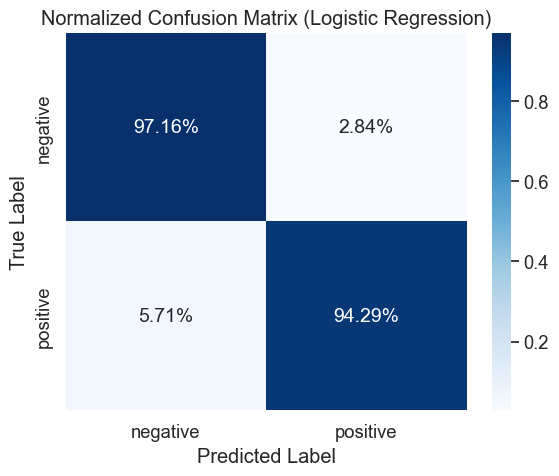

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Generate confusion matrix
cm = confusion_matrix(y_test, lr1_pred, labels=["negative", "positive"])

# Create a DataFrame for display
df_cm = pd.DataFrame(cm, index=["negative", "positive"], columns=["negative", "positive"])

# Plot normalized heatmap
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.2)
sns.heatmap(df_cm.div(df_cm.sum(axis=1), axis=0), annot=True, fmt='.2%', cmap='Blues',
            annot_kws={"size": 14})
plt.title("Normalized Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [42]:
df_cm

,negative,positive
negative,1916,56
positive,93,1535


In [44]:
testing_df[(y_test=='positive') & (lr1_pred=='negative')]


,sentence,label
384,feeling humorous put cold callers hold,positive
14442,fight feeling overwhelmed,positive
4997,lectures,positive
9741,spend day bed im feeling adventurous couch get...,positive
7999,im still feeling keen whole billy dee lee tria...,positive
...,...,...
5211,im still feeling incredibly overwhelmed entire...,positive
10369,feeling bit overwhelmed,positive
645,sick cold amp feeling well wondering would eve...,positive
6381,also feeling completely overwhelmed incredibly...,positive


In [45]:
list(df.loc[7511])

['i feel an urgency to introduce readers to the amazing and touching story of anna iya and erik',
 'surprise',
 'positive']

## LSTM

In [46]:
def load_data(file_path): 
    
    df = pd.read_csv(file_path)
    return df



REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):    
    
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

def process_texts(file_dir: str, is_train: bool) -> None:    
    all_texts = []    
    for file_name in os.listdir(file_dir):        
        if is_train and file_name.startswith('cv9'):            
            continue        
        if not is_train and not file_name.startswith('cv9'):            
            continue        
        file_path = os.path.join(file_dir, file_name)        
        cleaned_text = clean_text(load_text(file_path))
        all_texts.append(cleaned_text)    
    return all_texts

In [47]:
def build_lstm_classifier(X_train, Y_train, X_test, Y_test,
                          MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM):    
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(13, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
   

In [48]:
file_path = 'data_clean.csv'
df = load_data(file_path) 

df['sentence'] = df['sentence'].apply(clean_text).str.replace('\d+', '')

print(df['sentence']) 

0                                    didnt feel humiliated
1        go feeling hopeless damned hopeful around some...
2                im grabbing minute post feel greedy wrong
3        ever feeling nostalgic fireplace know still pr...
4                                          feeling grouchy
                               ...                        
17995    keep feeling like someone unkind wrong think g...
17996    im feeling little cranky negative doctors appo...
17997    feel useful people gives great feeling achieve...
17998    im feeling comfortable derby feel though start...
17999    feel weird meet w people tet like dont talk fa...
Name: sentence, Length: 18000, dtype: object


In [49]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['sentence'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15996 unique tokens.


In [50]:
X = tokenizer.texts_to_sequences(df['sentence'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (18000, 250)


In [51]:
Y = pd.get_dummies(df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (18000, 2)


In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 2020)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(14400, 250) (14400, 2)
(3600, 250) (3600, 2)


In [59]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


In [60]:
print("Unique y_train:", np.unique(y_train))
# Output should be: [0 1]


Unique y_train: [0 1]


In [61]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.callbacks import EarlyStopping
import tensorflow as tf

def build_lstm_classifier(MAX_NB_WORDS, EMBEDDING_DIM, INPUT_LENGTH, NEURONS=100, LR=0.001):
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=INPUT_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(NEURONS, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))  # For binary classification
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
                  metrics=['accuracy'])
    print(model.summary())
    return model

# Train
EPOCHS = 5
BATCH_SIZE = 64
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100

model1 = build_lstm_classifier(MAX_NB_WORDS, EMBEDDING_DIM, INPUT_LENGTH=X.shape[1], 
                               NEURONS=100, LR=0.001)

history1 = model1.fit(X_train, y_train, 
                      epochs=EPOCHS, batch_size=BATCH_SIZE,
                      validation_split=0.1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 101s 473ms/step - accuracy: 0.6485 - loss: 0.5920 - val_accuracy: 0.9431 - val_loss: 0.1642
Epoch 2/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 145s 489ms/step - accuracy: 0.9678 - loss: 0.0993 - val_accuracy: 0.9535 - val_loss: 0.1362
Epoch 3/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 94s 463ms/step - accuracy: 0.9875 - loss: 0.0422 - val_accuracy: 0.9528 - val_loss: 0.1436
Epoch 4/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 138s 442ms/step - accuracy: 0.9921 - loss: 0.0242 - val_accuracy: 0.9500 - val_loss: 0.1688
Epoch 5/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 89s 440ms/step - accuracy: 0.9948 - loss: 0.0183 - val_accuracy: 0.9417 - val_loss: 0.2127


In [64]:
accr1 = model1.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr1[0], accr1[1]))


113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9349 - loss: 0.2330
Test set
  Loss: 0.234
  Accuracy: 0.938


In [65]:
def predict_mood(text, model, tokenizer, max_len=100):
    import numpy as np
    from keras.utils import pad_sequences

    # Clean the input text (same way you cleaned training data)
    def clean_text(text):    
        text = text.lower()
        text = re.sub(r'[/(){}\[\]\|@,;]', ' ', text)
        text = re.sub(r'[^0-9a-z #+_]', '', text)
        text = text.replace('x', '')
        text = ' '.join(word for word in text.split() if word not in STOPWORDS)
        return text

    text_clean = clean_text(text)

    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([text_clean])
    padded = pad_sequences(seq, maxlen=max_len)

    # Predict
    prob = model.predict(padded)[0][0]
    label = "positive" if prob >= 0.5 else "negative"

    print(f"\n📝 Input: {text}")
    print(f"📈 Probability: {prob:.2f}")
    print(f"💡 Predicted Mood: {label}")


In [67]:
predict_mood("I feel completely exhausted and worthless today.", model1, tokenizer)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step

📝 Input: I feel completely exhausted and worthless today.
📈 Probability: 0.00
💡 Predicted Mood: negative
